In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import tqdm

import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms.v2 import functional as F

We'll make functions for loading annotations from jon files, loading images and annotations into one variable and extracting annotated centers.

In [3]:
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_images_and_annotations(image_folder, annotations):
    image_data = []
    for filename, annotation in annotations.items():
        #image_path = os.path.join(image_folder, filename)
        image_path = os.path.join(image_folder, annotation.get('filename'))
        image = cv2.imread(image_path)  # Load image using OpenCV
        if image is None:
            print(f"Error: Unable to load image '{image_path}'")
            continue
        
        # Extract annotations for the current image
        regions = annotation.get('regions', {})
        rod_centers = [(region['shape_attributes']['cx'], region['shape_attributes']['cy']) for region in regions.values()]
        
        image_data.append({'image': image, 'annotations': rod_centers})
    
    return image_data

def get_centers(annotations, filename):
    centers = []
    for annotation_filename, annotation_data in annotations.items():
        if annotation_data["filename"] == filename:
            regions = annotation_data.get("regions", {})
            for region_data in regions.values():
                shape_attributes = region_data.get("shape_attributes", {})
                center = (int(shape_attributes.get("cx")), int(shape_attributes.get("cy")))
                centers.append(center)
    return centers

Now lets load the data and take a look.

In [ ]:
train_folder_path = 'segmentation_dataset/train_data'
test_folder_path = 'segmentation_dataset/test_data'

# Load annotations from the JSON file
train_json_file = os.path.join(train_folder_path, 'train_labels.json')
train_annotations = load_annotations(train_json_file)

test_json_file = os.path.join(test_folder_path, 'test_labels.json')
test_annotations = load_annotations(test_json_file)

# Load images and annotations
image_data = load_images_and_annotations(train_folder_path, train_annotations)

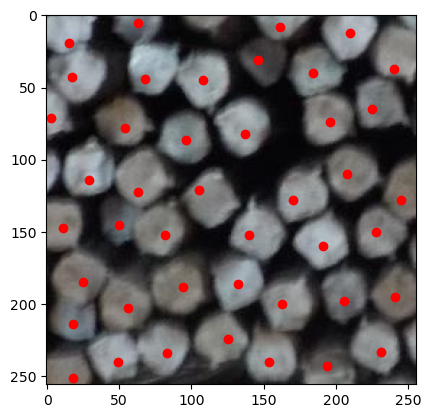

In [5]:
# Example: Accessing the first image and its annotations
first_image = image_data[4]['image']
first_annotations = image_data[4]['annotations']

plt.imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
for cx, cy in first_annotations:
    plt.plot(cx, cy, 'ro')  # Plot red circles at the rod centers
plt.show()

Great, now we are going to create a function that will use image and annotated centers and create a mask representing presence of rods in the image.

In [6]:
def detect_blobs(image, annotations):

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = np.zeros((image.shape[0] + 2, image.shape[1] + 2), dtype=np.uint8)
    #mask = np.zeros_like(image, dtype=np.uint8)

    for center in annotations:

        #center_coordinates = tuple(map(int, center))
        cv2.floodFill(image, mask, center, 255, loDiff = 3, upDiff = 3)

    mask = mask[1:-1, 1:-1]
    return mask

In the function below we take detected mask and make sure that only pixels in given proximity to centers are labeled as 1.

In [8]:
def filter_mask_by_centers(mask, centers, radius):
    # Create a mask to store all the circular regions
    circle_mask = np.zeros_like(mask, dtype=np.uint8)
    for center in centers:
        cx, cy = center
        # Draw a circular region around each center
        cv2.circle(circle_mask, (cx, cy), radius, 255, -1)
    # Perform a bitwise AND operation between the input mask and the circle mask
    filtered_mask = cv2.bitwise_and(mask, circle_mask)
    return filtered_mask

In [9]:
def apply_color_segmentation_and_blob_detection(image_folder, output_folder, annotations,
                                                 win=11, validation_split=0):

    # creating directory for masks                                             
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    val_image_folder = os.path.join(os.path.dirname(image_folder), "val_data")
    val_output_folder = os.path.join(os.path.dirname(output_folder), "val_masks")

    filenames = [filename for filename in os.listdir(image_folder) if (filename.endswith('.jpg') or filename.endswith('.JPG'))]

    if validation_split > 0:
        if not os.path.exists(val_image_folder):
            os.makedirs(val_image_folder)
        if not os.path.exists(val_output_folder):
            os.makedirs(val_output_folder)

        train_files, val_files = train_test_split(filenames, test_size=validation_split, random_state=42)
    #===========================================================================================================================
    #mask generation
    for filename in filenames:
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to load image '{image_path}'")
            continue

        centers = get_centers(annotations, filename)
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = cv2.adaptiveThreshold(gray_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,win,0)

        # Detect blobs using annotations
        blob_mask = filter_mask_by_centers(mask,centers,15)

        mask_filename = os.path.join(output_folder, os.path.splitext(filename)[0] + '_mask.jpg')
        cv2.imwrite(mask_filename, blob_mask)

    #moving part of files to validation set
    if validation_split > 0:
        for filename in val_files:
            image_path = os.path.join(image_folder, filename)
            mask_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '_mask.jpg')
            shutil.move(image_path, val_image_folder)
            shutil.move(mask_path, val_output_folder)

    plt.imshow(mask)
    plt.show()

In [10]:
train_output_folder = 'segmentation_dataset/train_masks'
test_output_folder = 'segmentation_dataset/test_masks'

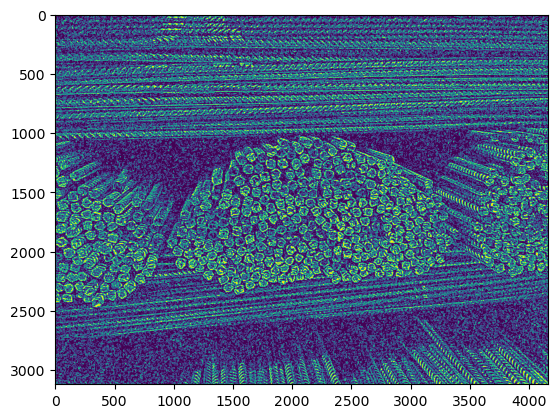

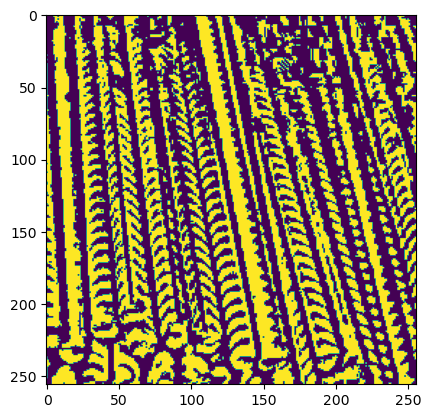

In [214]:
apply_color_segmentation_and_blob_detection(test_folder_path, test_output_folder, test_annotations, win=21)
apply_color_segmentation_and_blob_detection(train_folder_path, train_output_folder, train_annotations, win=21, validation_split=0.1)

Here we can see masks generated with adaptive threshold method, before applying to them function filter_mask_by_centers.

Now we are going to define a class for our model - UNET.

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        x = torch.sigmoid(x)

        return x

Class for loading images and masks from folders and applying augmentations.

In [12]:
class RodesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [filename for filename in os.listdir(image_dir) if filename.lower().endswith(('.jpg'))]#os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_filename = self.images[index].replace(".jpg", "_mask.jpg").replace(".JPG", "_mask.jpg")
        mask_path = os.path.join(self.mask_dir, mask_filename)
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        #mask[mask == 255.0] = 1.0
        mask = np.round(mask / 255.0)

        if self.transform is not None:

            augmentations = self.transform(image=image, mask=mask)#np.expand_dims(mask, axis=1))
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask#np.squeeze(mask, axis=1)

In [14]:
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
'''
train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    T.RandomRotation(35),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
])

val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    T.ToTensor(),
    T.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
])

class CustomTransform(object):
    def __init__(self, image_transform, mask_transform):
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __call__(self, image, mask):
        # Apply transformations to both image and mask
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        return image, mask

train_transform = CustomTransform(
    image_transform=T.Compose([
        T.ToPILImage(),
        T.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        T.RandomRotation(35),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.1),
        T.ToTensor(),
        T.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),  # Normalization for image
    ]),
    mask_transform=T.Compose([
        T.ToPILImage(),
        T.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        T.ToTensor(),
        T.Normalize(mean=[0.0], std=[1.0]),  # Normalization for mask
    ])
)

val_transforms = CustomTransform(
    image_transform=T.Compose([
        T.ToPILImage(),
        T.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        T.ToTensor(),
        T.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),  # Normalization for image
    ]),
    mask_transform=T.Compose([
        T.ToPILImage(),
        T.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        T.ToTensor(),
        T.Normalize(mean=[0.0], std=[1.0]),  # Normalization for mask
    ])
)

'''

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_folder_path = 'segmentation_dataset/val_data'
val_output_folder = 'segmentation_dataset/val_masks'

train_dataset = RodesDataset(train_folder_path, train_output_folder, transform=train_transform)
val_dataset = RodesDataset(val_folder_path, val_output_folder, transform=val_transform)


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)#torch.utils.data._utils.collate.collate)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [17]:
model = UNET()

In [34]:
if torch.cuda.is_available():

    device = torch.device('cuda')
    torch.cuda.set_device(0)
    # Set the maximum memory fraction PyTorch can use
    torch.cuda.set_per_process_memory_fraction(0.5, device=0)  # Example: limit to 50% of available GPU memory
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Device: ', device)
model.to(device)

#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Device:  cuda


In [18]:
best_model_path = "best_model.pth"

try:
    model.load_state_dict(torch.load(best_model_path))
    print("Last saved model loaded.")
except FileNotFoundError:
    print("No last saved model found. Starting training with a new model.")

Last saved model loaded.


And finally the training loop. Loss function chosen is binary cross entropy with logits

In [ ]:
loss_history = []
val_loss_history = []

patience = 2
best_val_loss = np.inf
counter = 0

for epoch in range(20):
    
    model.train()
    batches_loss = []
    progress_bar = tqdm.tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False)

    for images, masks in progress_bar: #train_dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        #loss = criterion(outputs, masks.unsqueeze(1))
        loss = torch.nn.functional.binary_cross_entropy(outputs, masks.unsqueeze(1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batches_loss.append(loss.item()/images.shape[0])
        #print(f'Loss: {loss.item()}')
    
    avg_loss = np.mean(batches_loss)
    loss_history.append(avg_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            #loss = criterion(outputs, masks.unsqueeze(1))
            loss = torch.nn.functional.binary_cross_entropy(outputs, masks.unsqueeze(1))
            
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)

    print(f'Epoch: {epoch}, Loss: {avg_loss}, Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        counter += 1
        if counter >= patience:
            print("Patience exceeded. Early stopping.")
            break

if best_val_loss != np.inf:
    model.load_state_dict(torch.load(best_model_path))
    print("Best model loaded.")
else:
    print("No model saved due to early stopping.")

Below we can see comparison between output and target mask of the trained model on exemplaty instance.

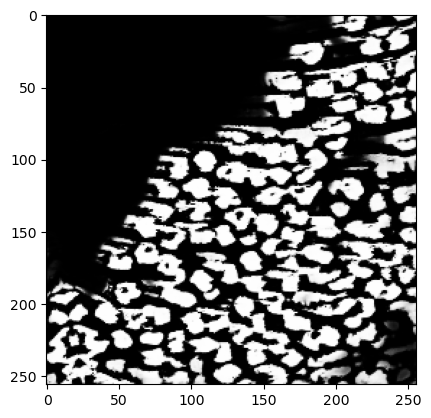

In [214]:
output_data = outputs[3].cpu().detach().numpy()

# Reshape the image data
reshaped_output_data = np.reshape(output_data, (256, 256, 1))

# Now you can visualize the reshaped image data
plt.imshow(cv2.cvtColor(reshaped_output_data, cv2.COLOR_GRAY2BGR))
plt.show()

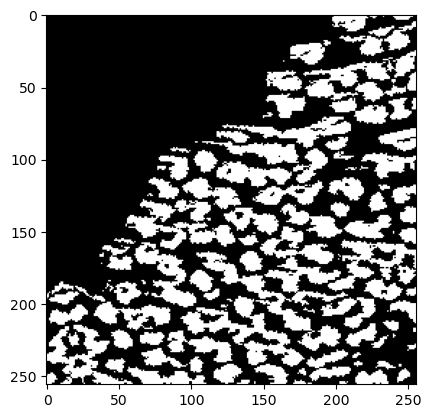

In [215]:
image_data = masks[3].cpu().detach().numpy()

# Reshape the image data
reshaped_image_data = np.reshape(image_data, (256, 256, 1))

# Now you can visualize the reshaped image data
plt.imshow(cv2.cvtColor(reshaped_image_data, cv2.COLOR_GRAY2BGR))
plt.show()

Time for inference.

In [19]:
test_image_data = load_images_and_annotations(test_folder_path, test_annotations)

Lets have a look at one of the test images.

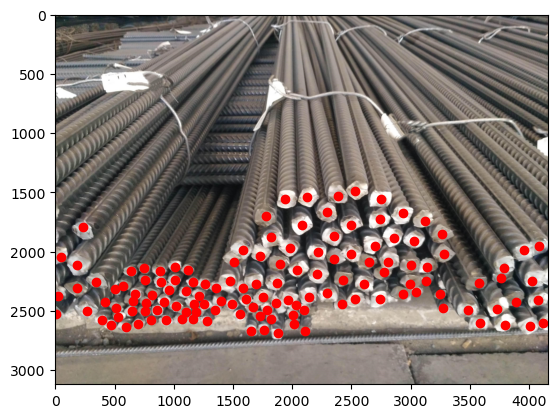

In [20]:
test_first_image = test_image_data[18]['image']
test_first_annotations = test_image_data[18]['annotations']

plt.imshow(cv2.cvtColor(test_first_image, cv2.COLOR_BGR2RGB))
for cx, cy in test_first_annotations:
    plt.plot(cx, cy, 'ro')  # Plot red circles at the rod centers
plt.show()

We'll create new dataset class because for inference we dont want the mask as a target but rather plain number of rodes in the image. We can also see that test images are much bigger resolution than those used for training so we are going to split each image into 4x4 images and resize them to 256x256 (size of training images).

In [163]:
class RodesTestDataset(Dataset):
    def __init__(self, image_data, transform=None):
        self.image_data = image_data
        self.transform = transform

    def __len__(self):
        return 16 * len(self.image_data)

    def __getitem__(self, index):

        file_index = index // 16
        part_index = index % 16

        image = self.image_data[file_index]['image']

        # Divide image and mask into 16 parts
        h, w, _ = image.shape
        h_step = h // 4
        w_step = w // 4
        image = image[h_step * (part_index // 4):h_step * (part_index // 4 + 1),
                            w_step * (part_index % 4):w_step * (part_index % 4 + 1)]

        image = Image.fromarray(image)
        image = np.array(image.resize((256, 256)))


        if self.transform is not None:

            augmentations = self.transform(image=image)#np.expand_dims(mask, axis=1))
            image = augmentations["image"]

        annotations = self.image_data[file_index]['annotations']
        annotations_in_part = []

        # annotations from the selected part of the image
        for cx, cy in annotations:
            # checking if the coordinates are within the boundaries of the part
            if (w_step * (part_index % 4) - 20 <= cx < w_step * (part_index % 4 + 1) + 20) and \
               (h_step * (part_index // 4) - 20 <= cy < h_step * (part_index // 4 + 1) + 20):
                # Adjust coordinates relative to the part
                adjusted_cx = cx - w_step * (part_index % 4)
                adjusted_cy = cy - h_step * (part_index // 4)
                annotations_in_part.append((adjusted_cx, adjusted_cy))

        target = len(annotations_in_part)

        return image, target#np.squeeze(mask, axis=1)

In [164]:
test_dataset = RodesTestDataset(test_image_data, transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
device = torch.device('cpu')

print('Device: ', device)
model.to(device)

best_model_path = "best_model.pth"

try:
    model.load_state_dict(torch.load(best_model_path))
    print("Last saved model loaded.")
except FileNotFoundError:
    print("No last saved model found. Starting training with a new model.")

Here we try to create a function that will detect, based on mask outputed by UNet, how many rods is there in a photo. Because the masks are of very irregular shapes we are going to apply morphological operations like erosion and dilation.

In [211]:
from scipy import ndimage
from scipy.ndimage import binary_erosion, binary_dilation

def count_connected_components(mask, erosion_iterations=1, dilation_iterations=3):

    mask = np.array(mask[0,:,:]).astype(np.uint8)

    kernel0 = np.ones((9,9),np.uint8)

    kernel1 = np.array([[0, 0, 1, 0, 0],
                      [0, 1, 1, 1, 0],
                      [1, 1, 1, 1, 1],
                      [0, 1, 1, 1, 0],
                      [0, 0, 1, 0, 0]]).astype(np.uint8)

    kernel2 = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1],]).astype(np.uint8)
    kernel3 = np.array([[0, 1, 0],
                      [1, 1, 1],
                      [0, 1, 0],]).astype(np.uint8)
    

    mask = cv2.dilate(mask,kernel1,iterations = 1)
    mask = cv2.erode(mask,kernel0,iterations = 1)

    mask = cv2.dilate(mask,kernel1,iterations = 1)
    mask = cv2.dilate(mask,kernel2,iterations = 1)
    mask = cv2.dilate(mask,kernel3,iterations = 2)


    # Apply connected components labeling
    labeled_mask, num_labels = ndimage.label(mask)

    return num_labels, np.expand_dims(mask, axis=2).astype(np.float32)

Lets check our soultion's performance. We are going to use RMSE loss between predicted number of rods and the ground truth value. We will also plot input image, mask produced by UNet and final mask obtained by morpological operations that was used for counting the rods.

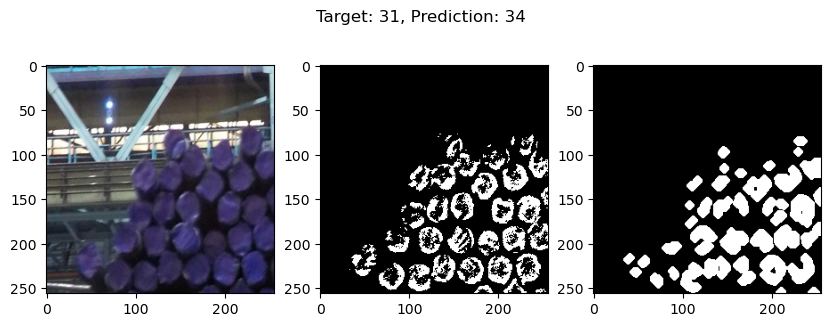

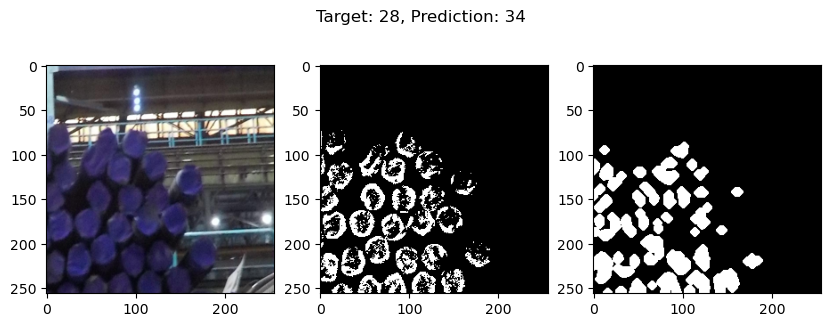

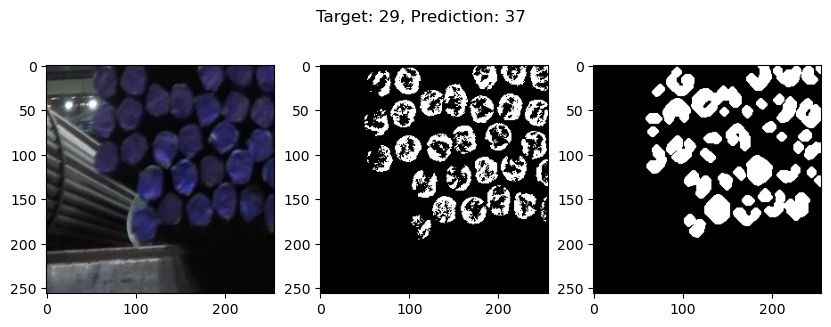

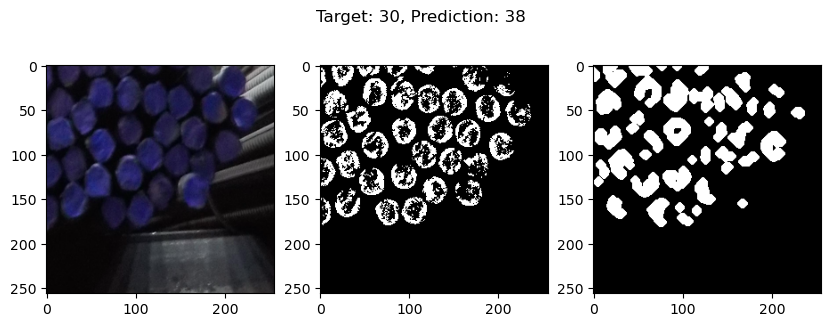

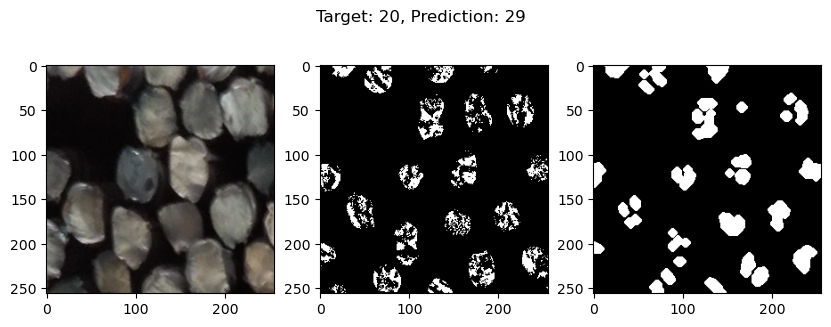

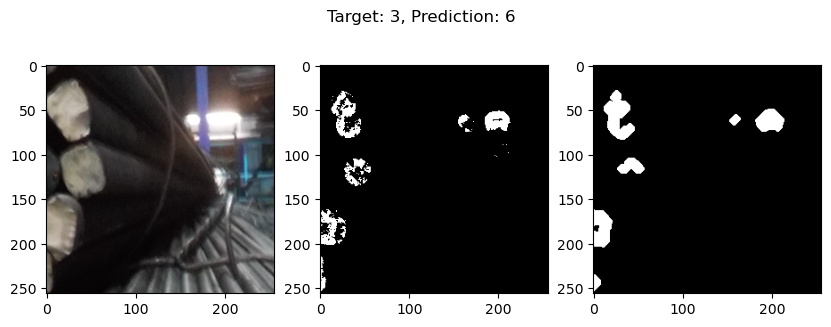

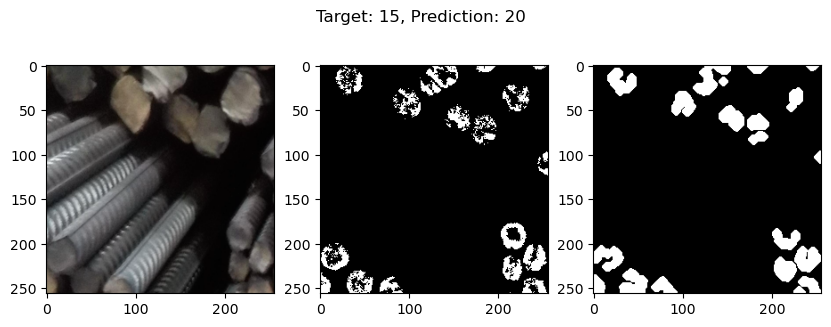

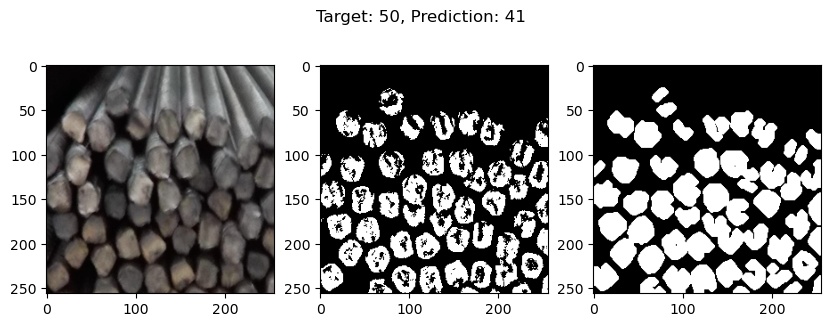

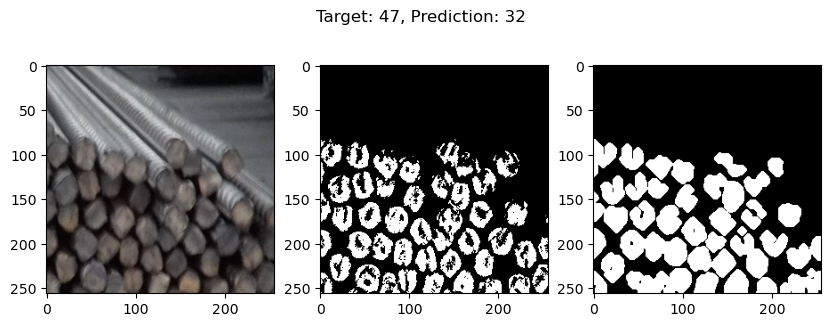

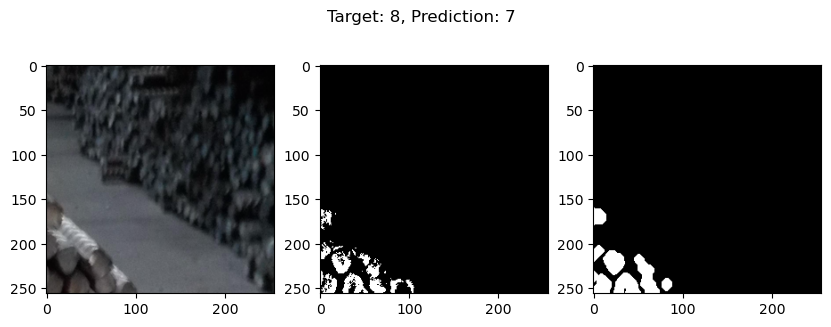

Test Loss: 9.22707423580786


In [221]:
criterion = nn.MSELoss()

model.eval()
test_loss = 0.0
i = 0

with torch.no_grad():
    for images, target in test_dataloader:
        images = images.to(device)
        # Forward pass
        outputs = model(images)[0]
        count, mask = count_connected_components(np.round(outputs.cpu()))
        # Calculate loss
        count_tensor = torch.tensor([count], dtype=torch.float32)  # Convert count to a tensor
        target_tensor = torch.tensor([target[0]], dtype=torch.float32)
        loss = torch.sqrt(criterion(count_tensor, target_tensor))
        
        test_loss += loss.item()

        if int(target_tensor) > 0 and i < 10:#loss.item() > 5:
            fig, ax = plt.subplots(1,3,figsize=(10,3.5))
            image = images[0].cpu().numpy()  # Convert tensor to NumPy array and move it to CPU
            image = np.transpose(image, (1, 2, 0))
            ax[0].imshow(image)
            #print(int(target[0]), count)
            ax[1].imshow(np.transpose(np.round(outputs.cpu()),(1,2,0)), cmap='gray')
            ax[2].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)) #np.transpose(mask, (1,2,0))
            fig.suptitle(f'Target: {int(target[0])}, Prediction: {count}')
            plt.show()
            i += 1


test_loss /= len(val_dataloader)

print(f'Test Loss: {test_loss}')

We can see that our solution can have problem where rods are densily located in the image, because detected objects start to merge into one big. But in standard cases our model was usually close to the correct number.